## Building NN for speech recogniton and optimize result 

In [36]:
import numpy as np
import os
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras import optimizers
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
%matplotlib inline
import pandas as pd

In [37]:
# our utils functions
from src.utils import *

# our classes
from classes.PreprocessData import *
from classes.EvaluateModel import *

In [58]:
folder_name="NNs/mix2_no_norm"
model_name="model2"

### Get data

In [59]:
# read data
train_df = pd.read_csv('data/data41mix+new_test_4.csv')
test_df = pd.read_csv('data/mix+new_test_4/data41mix2_test.csv')

### PREPROCESS DATA

In [60]:
# initialize preprocess class
preprocess = PreprocessData()

In [61]:
# # split data, normalize, shuffle
X_train, y_train = preprocess.preprocess_data(train_df, normalize=False)
X_test, y_test = preprocess.preprocess_data(test_df, normalize=False)
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train=scaler.transform(X_train)
# X_test=scaler.transform(X_test)

In [62]:
print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

Size of training matrix: (34697, 2808)
Size of testing matrix: (5205, 2808)


In [63]:
unique_words = set(y_train)
print(unique_words)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0}


In [64]:
class_size = len(set(y_train))

In [65]:
y_train = preprocess.categorize_y(y_train, class_size)
y_test = preprocess.categorize_y(y_test, class_size)

#### BUILD MODEL

In [66]:
#get number of columns in training data
n_cols = X_train.shape[1]

In [67]:
model = Sequential()

#add layers to model
model.add(Dense(150, activation='relu', input_shape=(n_cols,)))
model.add(Dense(150, activation='relu'))
model.add(Dense(41, activation='softmax'))

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 150)               421350    
_________________________________________________________________
dense_8 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_9 (Dense)              (None, 41)                6191      
Total params: 450,191
Trainable params: 450,191
Non-trainable params: 0
_________________________________________________________________


In [69]:
# compile model parameters
model.compile(optimizer='Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

In [1]:
#train model
history = model.fit(X_train, y_train, epochs=32, batch_size=32,  validation_split=0.15, verbose=0)

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

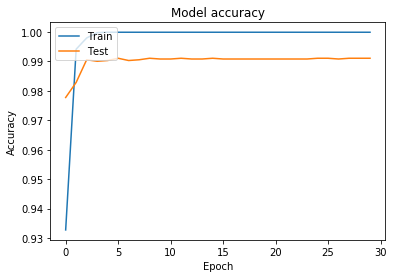

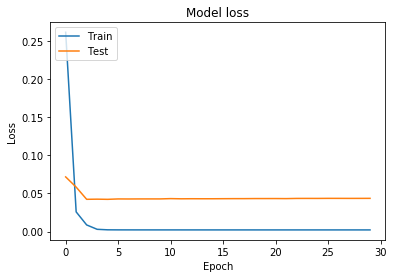

In [20]:
# relu / Adeleta
plot_hist(history)

#### SAVE MODEL

In [71]:
# Creates a HDF5 file 'my_model.h5'
model.save('models/{path}/{model}.h5'.format(path=folder_name,model=model_name))
# Deletes the existing model
del model

### Evaluate model

In [72]:
y_train2 = preprocess.uncategorize_y(y_train)
y_test2 = preprocess.uncategorize_y(y_test)

In [73]:
# initialize evaluate model
evaluate = EvaluateModel("MixModel_NN", "sequential", "normal", "models/NNs/mix2_no_norm", "scaler_values.csv","dict41.txt", class_size=class_size)

In [74]:
evaluate.y_train = preprocess.categorize_y(y_train2, evaluate.class_size)
evaluate.y_test = preprocess.categorize_y(y_test2, evaluate.class_size)

In [75]:
# get model
models = evaluate.get_models()

In [2]:
target = preprocess.uncategorize_y(evaluate.y_test)

result, predicted_labels = evaluate.calculate_res(models, h1=0.9, h2=0.5, X=X_test, target=target)

In [3]:
print("Accuracy: " + str(np.mean(result)))

### RESULT DATA RESULTS

**Accuracy on unseen test data (mix model)**

* Normal Accuracy: 99.10

* Accuracy where (h1>=0.9): 98.38

* Accuracy where (h1>=0.9 and h1-h2>=0.5): 98.38
* Accuracy where (h1>=0.9 and h1-h2>=0.9): 98.10

In [128]:
# Create the random grid
param_grid = [
    {      
            'dense': [150, 200, 250, 275],
            'activation': ['sigmoid', 'tanh','relu'],
            'optimizer': ['adam','RMSprop','Adadelta']
    }
]

param_combination = []
para_label=['dense', 'activation', 'optimizer']

# parameter list for storing all possible combinations
param_list = []

In [129]:
# create all possible parameters combinations for optimizations
for n_dense in param_grid[0]['dense']:
        for n_act in param_grid[0]['activation']:
            for n_opt in param_grid[0]['optimizer']:
                param_dict = dict(zip(para_label, [n_dense, n_act, n_opt]))
                param_list.append(param_dict)

In [132]:
# itereate throgh every parameter combination for every current word

folder_name="NNs/mix2"
model_name="mix"

max_accuracy=0

result_dict={}

for param_i,_ in enumerate(param_list):
    
    model = Sequential()
    
    # paramas
    dense_p = param_list[param_i]['dense']
    activation_p = param_list[param_i]['activation']
    optimizer_p = param_list[param_i]['optimizer']

    #add layers to model
    model.add(Dense(dense_p, activation=activation_p, input_shape=(n_cols,)))
    model.add(Dense(dense_p, activation=activation_p))
    model.add(Dense(41, activation='softmax'))
    
    # compile model parameters
    model.compile(optimizer=optimizer_p, loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    #train model
    model.fit(X_train, y_train, epochs=30, batch_size=30,validation_split=0.15, verbose=0)
    # Creates a HDF5 file 'my_model.h5'
    model.save('models/{path}/{model}.h5'.format(path=folder_name,model=model_name))
    # Deletes the existing model
    del model
    
    
    y_train2 = preprocess.uncategorize_y(y_train)
    y_test2 = preprocess.uncategorize_y(y_test)

    # initialize evaluate model
    evaluate = EvaluateModel("MixModel_NN", "normal", "models/NNs/mix2", class_size=class_size)

    evaluate.y_train = preprocess.categorize_y(y_train2, evaluate.class_size)
    evaluate.y_test = preprocess.categorize_y(y_test2, evaluate.class_size)

    # get model
    models = evaluate.get_models()

    target = preprocess.uncategorize_y(evaluate.y_test)
    result, predicted_labels = evaluate.calculate_res(models, h1=0.9, h2=0.5, X_test=X_test, target=target)

    accuracy = np.mean(result)
    result_dict[accuracy]=param_list[param_i]

In [133]:
# optimization values
result_dict

{0.9599390376660135: {'dense': 150,
  'activation': 'sigmoid',
  'optimizer': 'adam'},
 0.9793163509688657: {'dense': 150, 'activation': 'relu', 'optimizer': 'adam'},
 0.9629871543653385: {'dense': 150,
  'activation': 'sigmoid',
  'optimizer': 'Adadelta'},
 0.9760505116481603: {'dense': 275, 'activation': 'relu', 'optimizer': 'adam'},
 0.9827999129109515: {'dense': 275,
  'activation': 'sigmoid',
  'optimizer': 'RMSprop'},
 0.973437840191596: {'dense': 150,
  'activation': 'tanh',
  'optimizer': 'Adadelta'},
 0.978880905726105: {'dense': 150,
  'activation': 'relu',
  'optimizer': 'RMSprop'},
 0.9808404093185282: {'dense': 200,
  'activation': 'relu',
  'optimizer': 'RMSprop'},
 0.9804049640757675: {'dense': 200,
  'activation': 'sigmoid',
  'optimizer': 'RMSprop'},
 0.969301110385369: {'dense': 200,
  'activation': 'sigmoid',
  'optimizer': 'Adadelta'},
 0.9767036795123013: {'dense': 200, 'activation': 'tanh', 'optimizer': 'adam'},
 0.9841062486392336: {'dense': 200,
  'activation': 